# Networks of persons in relation to organisations


* Pajek book chapter ...
* Cf. [this notebook](https://github.com/Sciences-historiques-numeriques/histoire_numerique_methodes/blob/main/analyse_reseaux/networkx_slicing_with_cores.ipynb) avec simple examples



In [1]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd


import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import seaborn as sns
import math
import os

In [2]:
### Librairies déjà installées avec Python
import pprint
import csv

import sqlite3 as sql

import time
import datetime
from dateutil import parser


from shutil import copyfile


In [3]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

import sys
from importlib import reload

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf
import network_analysis_functions as naf

In [4]:
print(reload(naf))  

<module 'network_analysis_functions' from 'c:\\Users\\rroll\\Documents\\GitHub\\2HS2179_militants-pour-la-paix\\notebooksJupyter\\network_analysis_functions.py'>


## Get the data from the triplestore

...  [compléter]


In [ ]:
## define SPARQL enpoint
endpoint = "https://ag132kz7jrzck2hf.allegrograph.cloud/repositories/peace/sparql"

In [6]:
query = """

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>


SELECT ?person (MIN(?pLabel) AS ?personLabel)
        (MIN(?birthYear) AS ?birthYear)
        ?relationship 
        ?organisation (MIN(?oLabel) AS ?organisationLabel)
        (COUNT(*) as ?n) 
        (GROUP_CONCAT(DISTINCT ?groupTypeLabel; separator=" | ") AS ?groupTypes) 
        #(GROUP_CONCAT(DISTINCT ?countryLabel; separator=" | ") AS ?countries) 

WHERE {
        GRAPH <https://github.com/Raphix93/2HS2179_militants-pour-la-paix/blob/main/wikidata/graph/imported-data.md>
        {
        {?person a wd:Q5;
           rdfs:label ?pLabel;
           wdt:P569 ?birthYear.
        }


        {?person wdt:P108 ?organisation.
        BIND('employment' AS ?relationship)
        }   
        UNION
        {?person wdt:P463 ?organisation.
        BIND('membership' AS ?relationship)
        }   
        UNION
        {?person wdt:P69 ?organisation.
        BIND('education' AS ?relationship)
        }  
        ?organisation rdfs:label ?oLabel;
                 wdt:P31 ?groupType.
        ?groupType rdfs:label ?groupTypeLabel         
        
        # OPTIONAL {
        #    ?organisation wdt:P17 ?country.
        #    ?country rdfs:label ?countryLabel.
        # }

         }        



    }

GROUP BY ?person ?relationship ?organisation   
ORDER by ?person 
"""

In [7]:
### Executer la requête avec les fonctions de la librairie locale
try:
    qr = spqf.get_json_sparql_result(endpoint,query)
    out = [l for l in spqf.sparql_result_to_list(qr)]
    print(len(out))
    pprint.pprint(out[100:103])
except Exception as e:
    print(e)    


679
[['http://www.wikidata.org/entity/Q133281500',
  'Christina Gibb',
  '1929',
  'employment',
  'http://www.wikidata.org/entity/Q17509124',
  'Chilton Saint James School',
  '3',
  'combined school | private school | secondary school'],
 ['http://www.wikidata.org/entity/Q133281500',
  'Christina Gibb',
  '1929',
  'employment',
  'http://www.wikidata.org/entity/Q1150437',
  'Victoria University of Wellington',
  '1',
  'public university'],
 ['http://www.wikidata.org/entity/Q133734026',
  'Henning Zierock',
  '1951',
  'membership',
  'http://www.wikidata.org/entity/Q133734335',
  'Society Culture of Peace',
  '1',
  'peace organization']]


## Inspect the data


In [8]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(out)
df_p.columns = ['uriPer', 'labelPer', 'birthYear', 'relaType', 'uriOrg', 'labelOrg', 'nTypes',
                'typesO']
print('Number: ',len(df_p))
df_p.iloc[10:13,:]


Number:  679


uriPer                     labelPer  \
10     http://www.wikidata.org/entity/Q105593  Friedrich Siegmund-Schultze   
11  http://www.wikidata.org/entity/Q105840219                    Gwyn Kirk   
12     http://www.wikidata.org/entity/Q105876       Horst-Eberhard Richter   

   birthYear    relaType                                    uriOrg  \
10      1885  employment  http://www.wikidata.org/entity/Q20266330   
11      1945  membership   http://www.wikidata.org/entity/Q5604092   
12      1923  employment    http://www.wikidata.org/entity/Q165980   

                               labelOrg nTypes      typesO  
10  Frederick William University Berlin      1  university  
11   Greenham Common Women's Peace Camp      1  peace camp  
12                 University of Vienna      1  university

# Mon graphe

C:\Users\rroll\AppData\Local\Temp\ipykernel_22540\431303960.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


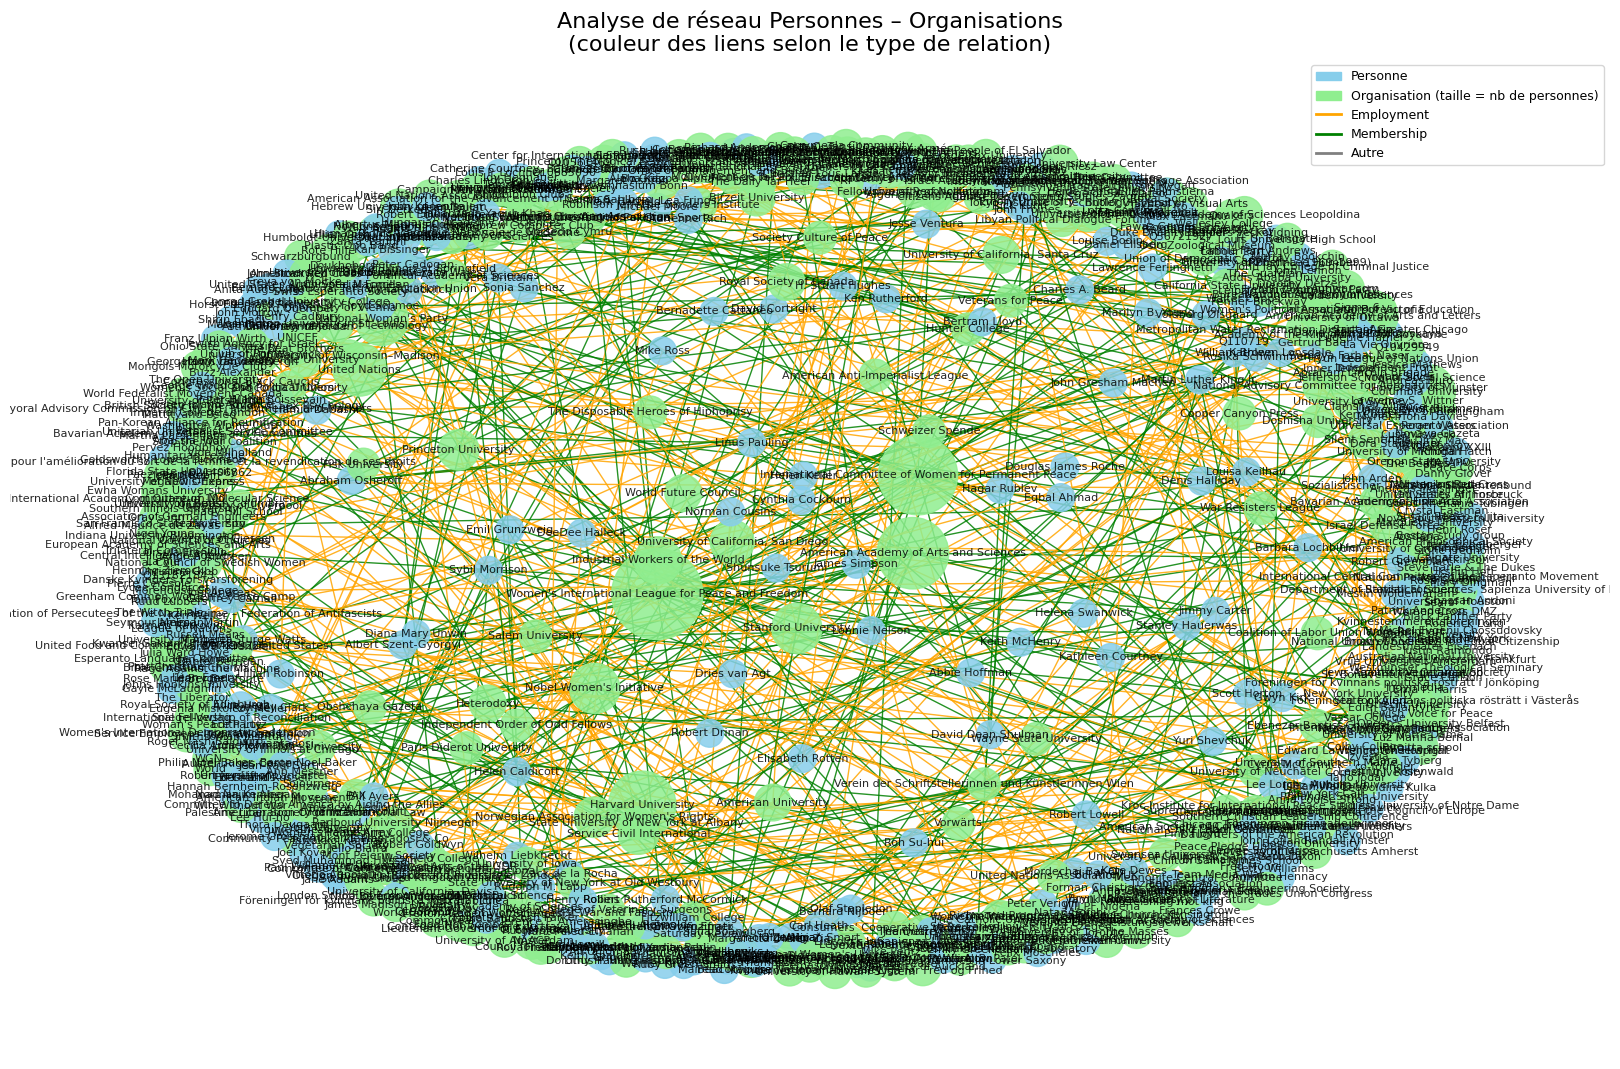

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Créer le graphe
G = nx.Graph()

# Ajouter les nœuds avec type et URI
for _, row in df_p.iterrows():
    G.add_node(row['labelPer'], type='person', uri=row['uriPer'])
    G.add_node(row['labelOrg'], type='organisation', uri=row['uriOrg'])
    G.add_edge(row['labelPer'], row['labelOrg'], relation=row['relaType'])

# Définir les couleurs d'arêtes selon la relation
relation_colors_map = {
    'employment': 'orange',
    'membership': 'green'
}

# Générer les listes de styles pour chaque arête
edge_colors = []
for u, v, d in G.edges(data=True):
    rel = d.get('relation', 'other')
    edge_colors.append(relation_colors_map.get(rel, 'gray'))  # couleur par défaut : gris

# Déterminer la taille des nœuds :
node_sizes = []
node_colors = []

for n in G.nodes:
    node_type = G.nodes[n]['type']
    degree = G.degree(n)

    if node_type == 'person':
        node_sizes.append(400)
        node_colors.append('skyblue')
    else:
        node_sizes.append(400 + 150 * degree)
        node_colors.append('lightgreen')

# Disposition en nuage
pos = nx.spring_layout(G, k=0.8, iterations=50, seed=42)

# Tracé du graphe
plt.figure(figsize=(16, 10))
nx.draw(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    node_size=node_sizes,
    edge_color=edge_colors,
    font_size=8,
    alpha=0.85
)

# Légende des types de nœuds
node_legend = [
    Patch(color='skyblue', label='Personne'),
    Patch(color='lightgreen', label='Organisation (taille = nb de personnes)')
]

# Légende des types de relation
edge_legend = [
    Line2D([0], [0], color='orange', lw=2, label='Employment'),
    Line2D([0], [0], color='green', lw=2, label='Membership'),
    Line2D([0], [0], color='gray', lw=2, label='Autre')
]

# Afficher les deux légendes
plt.legend(handles=node_legend + edge_legend, loc='best', fontsize=9)

plt.title("Analyse de réseau Personnes – Organisations\n(couleur des liens selon le type de relation)", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


C:\Users\rroll\AppData\Local\Temp\ipykernel_5556\948491392.py:90: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



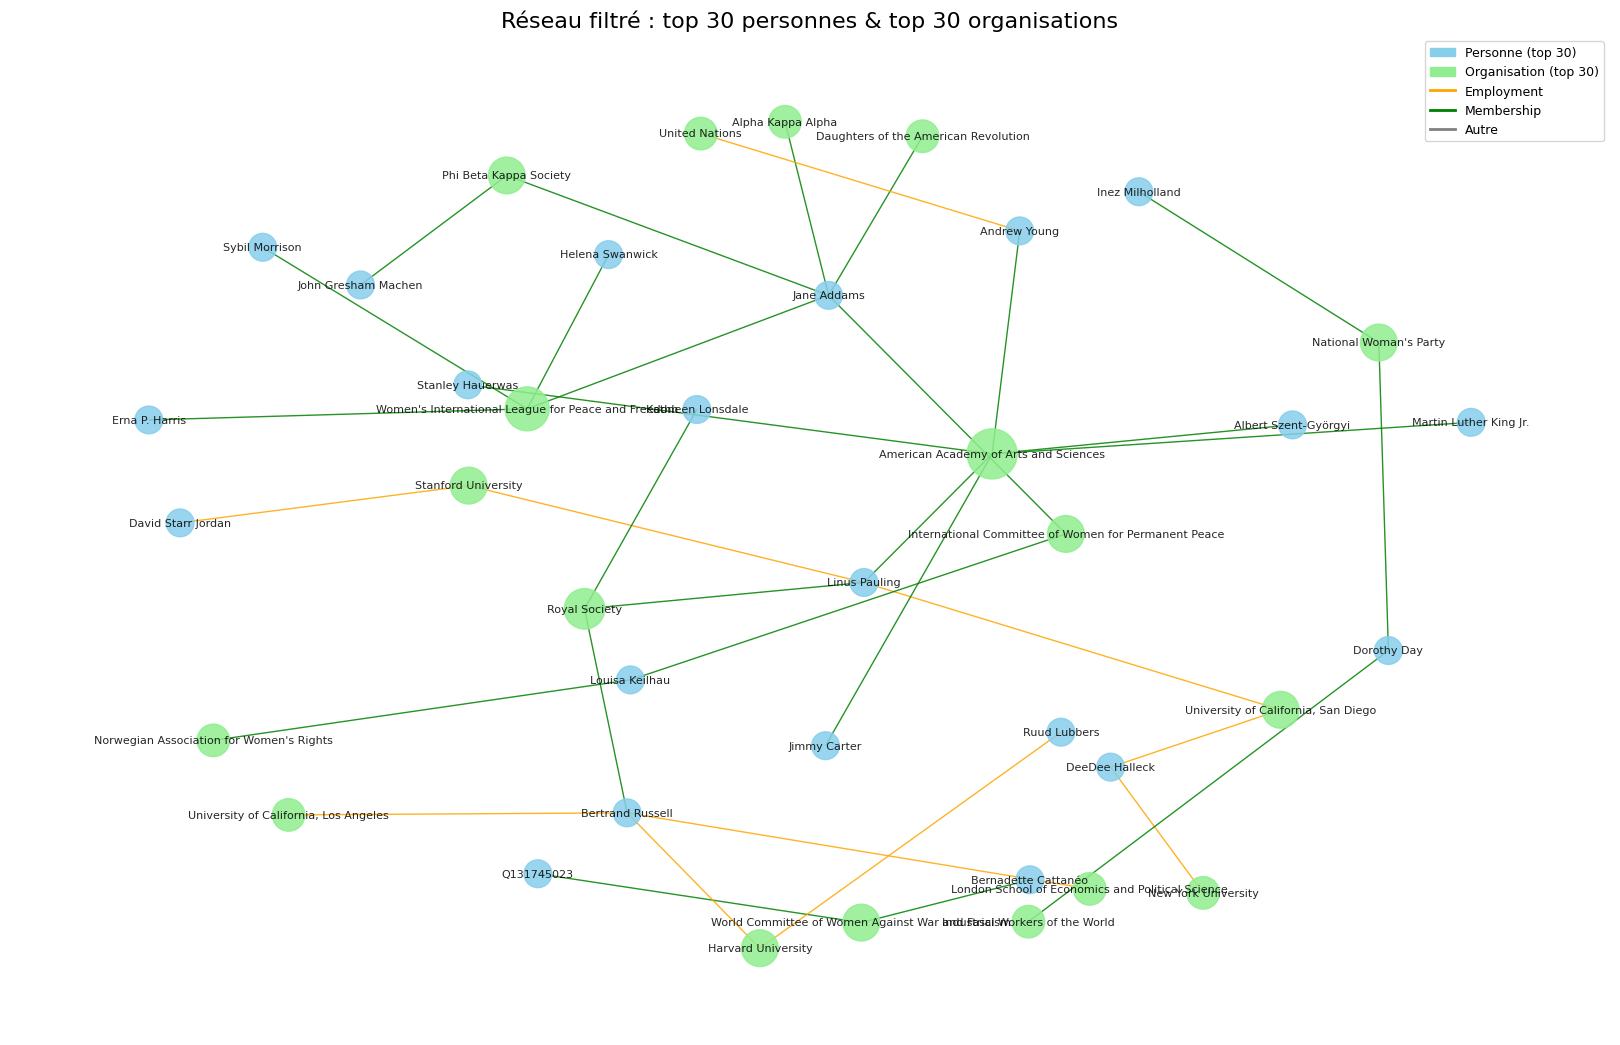

In [93]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# --- 1. Créer le graphe ---
G_full = nx.Graph()

for _, row in df_p.iterrows():
    G_full.add_node(row['labelPer'], type='person', uri=row['uriPer'])
    G_full.add_node(row['labelOrg'], type='organisation', uri=row['uriOrg'])
    G_full.add_edge(row['labelPer'], row['labelOrg'], relation=row['relaType'])

# --- 2. Définir les top personnes et organisations à garder ---
# top 30 personnes + top 30 organisations par degré
top_n_persons = 30
top_m_orgs = 30

# Identifier les meilleurs nœuds par type
persons = [n for n, d in G_full.nodes(data=True) if d['type'] == 'person']
orgs = [n for n, d in G_full.nodes(data=True) if d['type'] == 'organisation']

top_persons = sorted(persons, key=lambda n: G_full.degree(n), reverse=True)[:top_n_persons]
top_orgs = sorted(orgs, key=lambda n: G_full.degree(n), reverse=True)[:top_m_orgs]

# --- 3. Sous-graphe filtré contenant uniquement les top noeuds et leurs liens valides ---
nodes_to_keep = set(top_persons + top_orgs)
edges_to_keep = [(u, v) for u, v in G_full.edges() if u in nodes_to_keep and v in nodes_to_keep]

G = nx.Graph()
for u, v in edges_to_keep:
    G.add_node(u, **G_full.nodes[u])
    G.add_node(v, **G_full.nodes[v])
    G.add_edge(u, v, **G_full.edges[u, v])

# --- 4. Affichage du sous-graphe ---
relation_colors_map = {
    'employment': 'orange',
    'membership': 'green'
}

edge_colors = []
for u, v, d in G.edges(data=True):
    rel = d.get('relation', 'other')
    edge_colors.append(relation_colors_map.get(rel, 'gray'))

node_sizes = []
node_colors = []

for n in G.nodes:
    node_type = G.nodes[n]['type']
    degree = G.degree(n)

    if node_type == 'person':
        node_sizes.append(400)
        node_colors.append('skyblue')
    else:
        node_sizes.append(400 + 150 * degree)
        node_colors.append('lightgreen')

# Disposition
pos = nx.spring_layout(G, k=0.8, iterations=50, seed=42)

plt.figure(figsize=(16, 10))
nx.draw(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    node_size=node_sizes,
    edge_color=edge_colors,
    font_size=8,
    alpha=0.85
)

# Légendes
node_legend = [
    Patch(color='skyblue', label='Personne (top {})'.format(top_n_persons)),
    Patch(color='lightgreen', label='Organisation (top {})'.format(top_m_orgs))
]

edge_legend = [
    Line2D([0], [0], color='orange', lw=2, label='Employment'),
    Line2D([0], [0], color='green', lw=2, label='Membership'),
    Line2D([0], [0], color='gray', lw=2, label='Autre')
]

plt.legend(handles=node_legend + edge_legend, loc='best', fontsize=9)
plt.title("Réseau filtré : top {} personnes & top {} organisations".format(top_n_persons, top_m_orgs), fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


In [76]:
import networkx as nx

# 1. Créer le graphe complet (déjà fait si tu as G)
# ...

# 2. Calculer la betweenness centrality (graphe complet)
betweenness = nx.betweenness_centrality(G, normalized=True)

# 3. Filtrer uniquement les organisations
betweenness_orgs = {
    node: score for node, score in betweenness.items()
    if G.nodes[node].get('type') == 'organisation'
}

# 4. Trier et afficher (facultatif)
sorted_betweenness = sorted(betweenness_orgs.items(), key=lambda x: x[1], reverse=True)

for org, score in sorted_betweenness[:10]:  # top 10
    print(f"{org}: {score:.4f}")


American Academy of Arts and Sciences: 0.0696
Women's International League for Peace and Freedom: 0.0475
Harvard University: 0.0334
Alpha Kappa Alpha: 0.0272
American Academy of Arts and Letters: 0.0246
National Woman's Party: 0.0228
International Committee of Women for Permanent Peace: 0.0226
Columbia University: 0.0222
United Nations: 0.0211
Brandeis University: 0.0174


In [77]:
import pandas as pd
import networkx as nx

# --- Charger ou définir ton DataFrame df_p ---
# Il doit contenir : labelPer, uriPer, labelOrg, uriOrg, relaType
# Exemple :
# df_p = pd.read_csv("ton_fichier.csv")  # décommente si tu as un fichier CSV

# --- Création du graphe ---
G = nx.Graph()

for _, row in df_p.iterrows():
    per_label = str(row['labelPer']) if pd.notna(row['labelPer']) else "Unknown Person"
    org_label = str(row['labelOrg']) if pd.notna(row['labelOrg']) else "Unknown Organisation"
    
    G.add_node(per_label, type='person', uri=row.get('uriPer', ''))
    G.add_node(org_label, type='organisation', uri=row.get('uriOrg', ''))
    
    G.add_edge(per_label, org_label, relation=row.get('relaType', ''))

# --- Calcul des centralités ---
try:
    eigenvector = nx.eigenvector_centrality(G, max_iter=1000)
except nx.PowerIterationFailedConvergence:
    print("⚠️ Eigenvector centrality did not converge. Utilisation de zéros.")
    eigenvector = {n: 0.0 for n in G.nodes}

betweenness = nx.betweenness_centrality(G, normalized=True)

# --- Extraire uniquement les organisations ---
org_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'organisation']

# --- Construire un DataFrame comparatif ---
df_compare = pd.DataFrame({
    'Organisation': org_nodes,
    'Eigenvector': [eigenvector.get(n, 0.0) for n in org_nodes],
    'Betweenness': [betweenness.get(n, 0.0) for n in org_nodes]
}).sort_values(by='Eigenvector', ascending=False)

# --- Affichage ou export ---
print(df_compare.head(10))  # affiche les 10 plus centrales

# Optionnel : sauvegarde CSV
df_compare.to_csv("centralites_organisations.csv", index=False)


                                          Organisation  Eigenvector  \
16   Women's International League for Peace and Fre...     0.602493   
123  International Committee of Women for Permanent...     0.344241   
165                                  Alpha Kappa Alpha     0.039041   
3                 Daughters of the American Revolution     0.038942   
147                             Phi Beta Kappa Society     0.037484   
167  National Union of Societies for Equal Citizenship     0.033281   
166                            League of Nations Union     0.033281   
97                              National Woman's Party     0.028791   
122           Norwegian Association for Women's Rights     0.027022   
288                                    Six Point Group     0.024578   

     Betweenness  
16      0.047550  
123     0.022614  
165     0.027179  
3       0.016796  
147     0.004495  
167     0.000000  
166     0.000000  
97      0.022831  
122     0.000920  
288     0.008824  


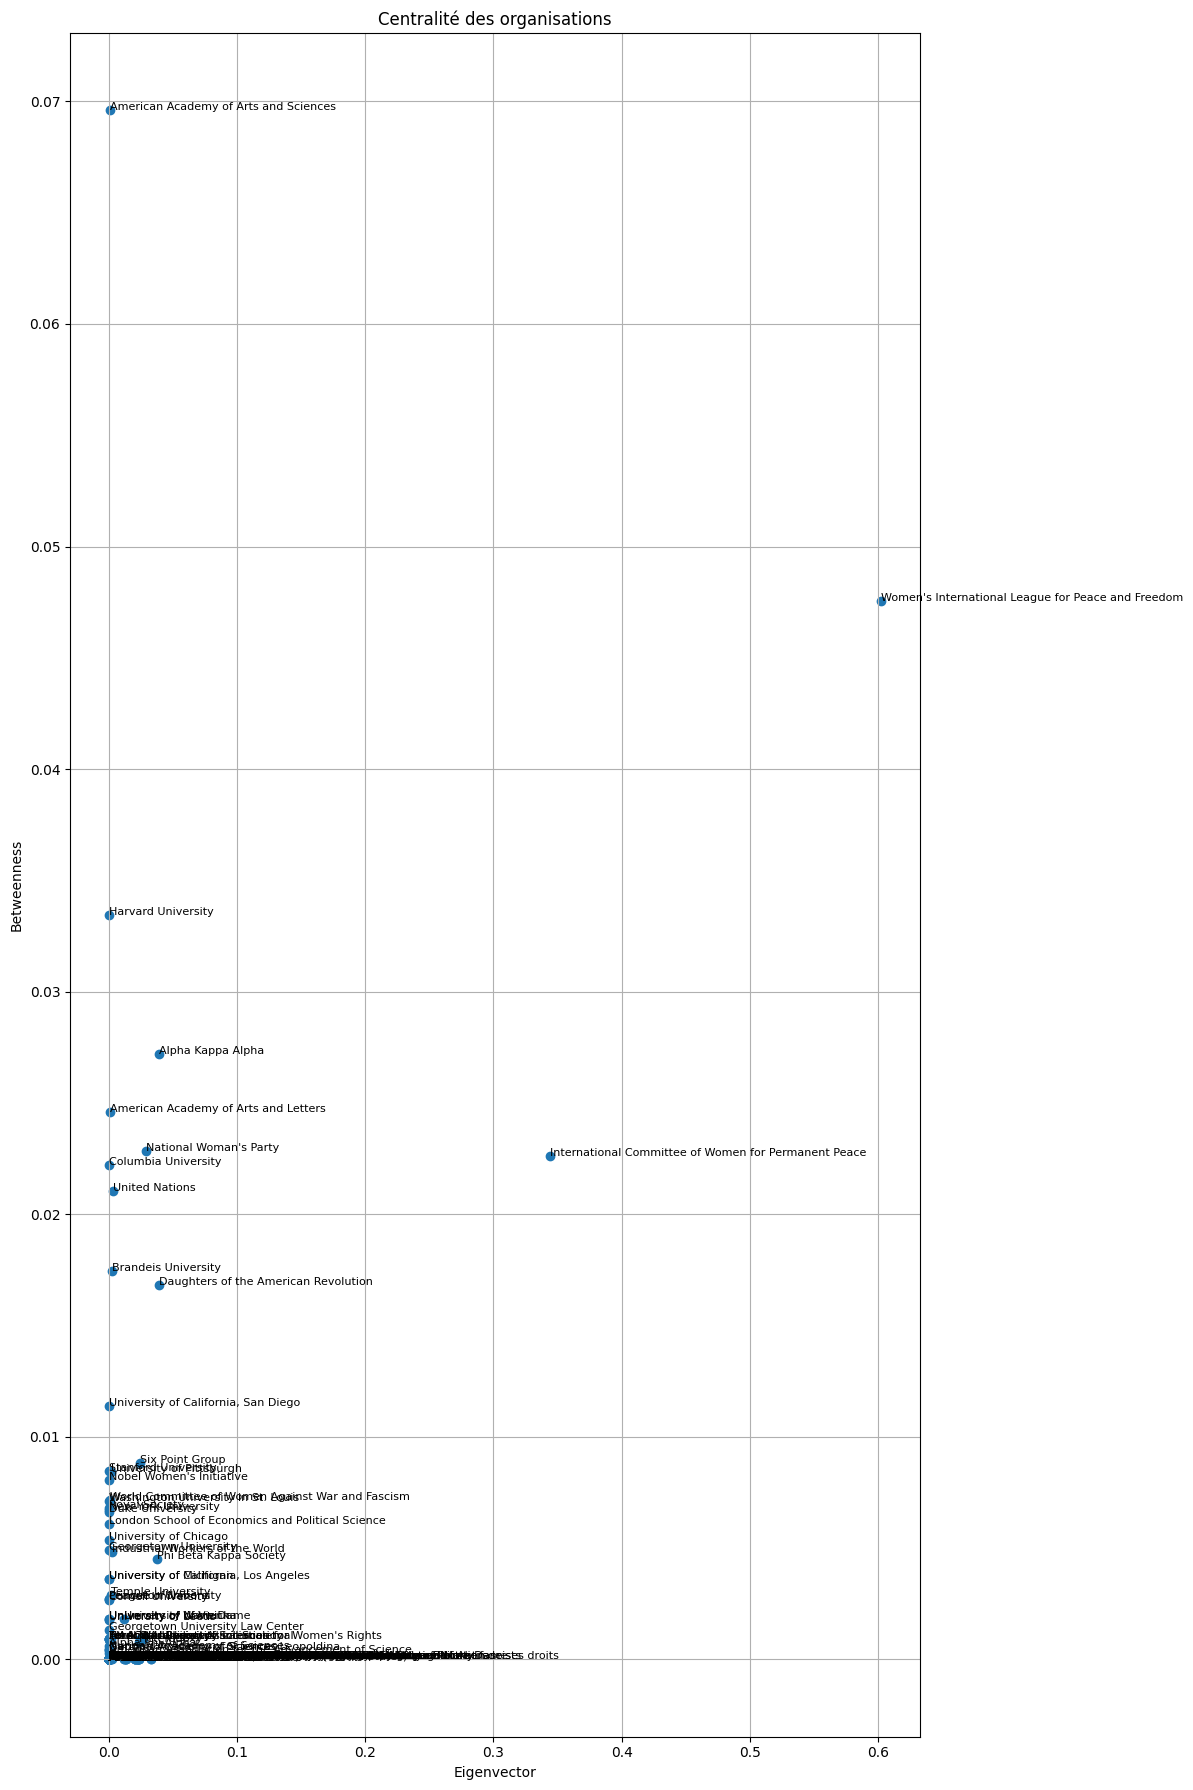

In [78]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# --- 2. Créer le graphe NetworkX ---
G = nx.Graph()

for _, row in df_p.iterrows():
    per_label = str(row['labelPer']) if pd.notna(row['labelPer']) else "Unknown Person"
    org_label = str(row['labelOrg']) if pd.notna(row['labelOrg']) else "Unknown Organisation"

    G.add_node(per_label, type='person', uri=row.get('uriPer', ''))
    G.add_node(org_label, type='organisation', uri=row.get('uriOrg', ''))

    G.add_edge(per_label, org_label, relation=row.get('relaType', ''))

# --- 3. Calculer les centralités ---
try:
    eigenvector = nx.eigenvector_centrality(G, max_iter=1000)
except nx.PowerIterationFailedConvergence:
    print("⚠️ Eigenvector centrality did not converge. Remplacé par 0.")
    eigenvector = {n: 0.0 for n in G.nodes}

betweenness = nx.betweenness_centrality(G, normalized=True)

# --- 4. Créer le DataFrame pour les organisations uniquement ---
org_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'organisation']

df_compare = pd.DataFrame({
    'Organisation': org_nodes,
    'Eigenvector': [eigenvector.get(n, 0.0) for n in org_nodes],
    'Betweenness': [betweenness.get(n, 0.0) for n in org_nodes]
}).sort_values(by='Eigenvector', ascending=False)

# --- 5. Visualisation avec matplotlib ---
plt.figure(figsize=(12, 18))

plt.scatter(df_compare['Eigenvector'], df_compare['Betweenness'])

for i, row in df_compare.iterrows():
    plt.text(row['Eigenvector'], row['Betweenness'], row['Organisation'], fontsize=8)

plt.xlabel('Eigenvector')
plt.ylabel('Betweenness')
plt.title('Centralité des organisations')
plt.grid(True)
plt.tight_layout()
plt.show()


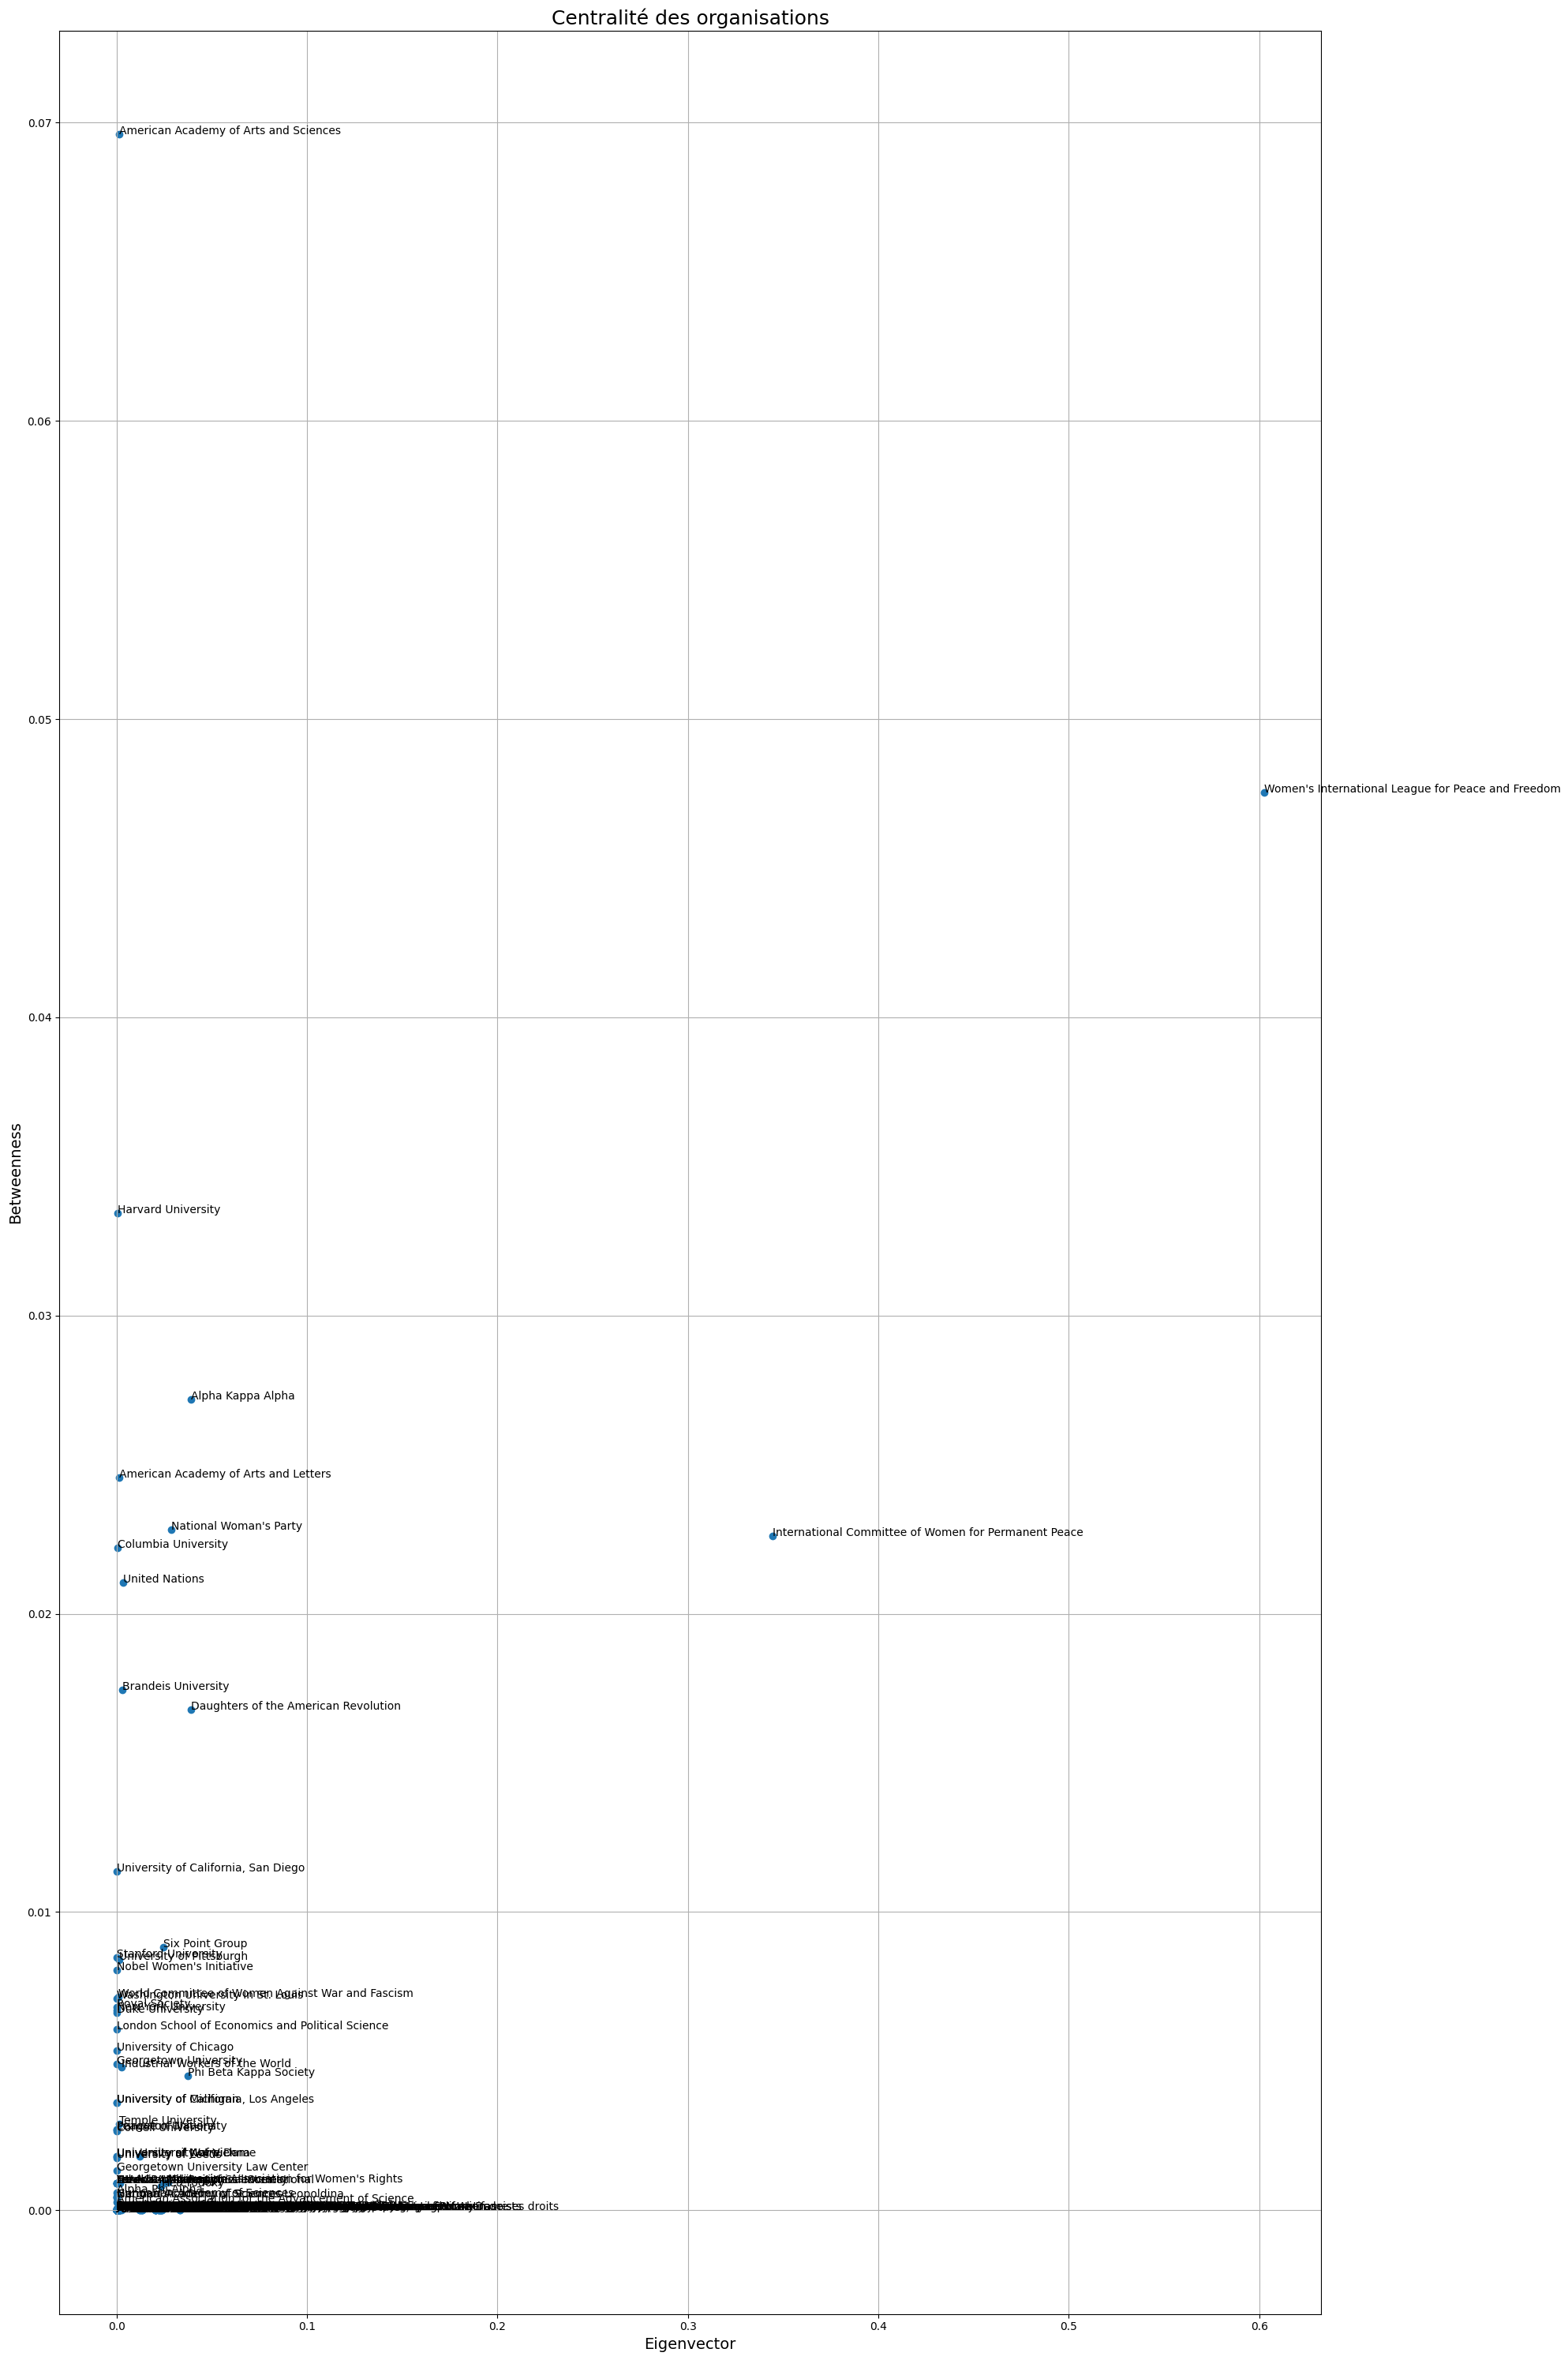

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 30))  # ✅ augmente la taille de la figure (largeur x hauteur)

# Scatter plot
plt.scatter(df_compare['Eigenvector'], df_compare['Betweenness'])

# Affichage des labels avec taille plus grande
for i, row in df_compare.iterrows():
    plt.text(row['Eigenvector'], row['Betweenness'], row['Organisation'], fontsize=10)  # ✅ fontsize augmenté

plt.xlabel('Eigenvector', fontsize=14)
plt.ylabel('Betweenness', fontsize=14)
plt.title('Centralité des organisations', fontsize=18)

plt.grid(True)
plt.tight_layout()
plt.show()


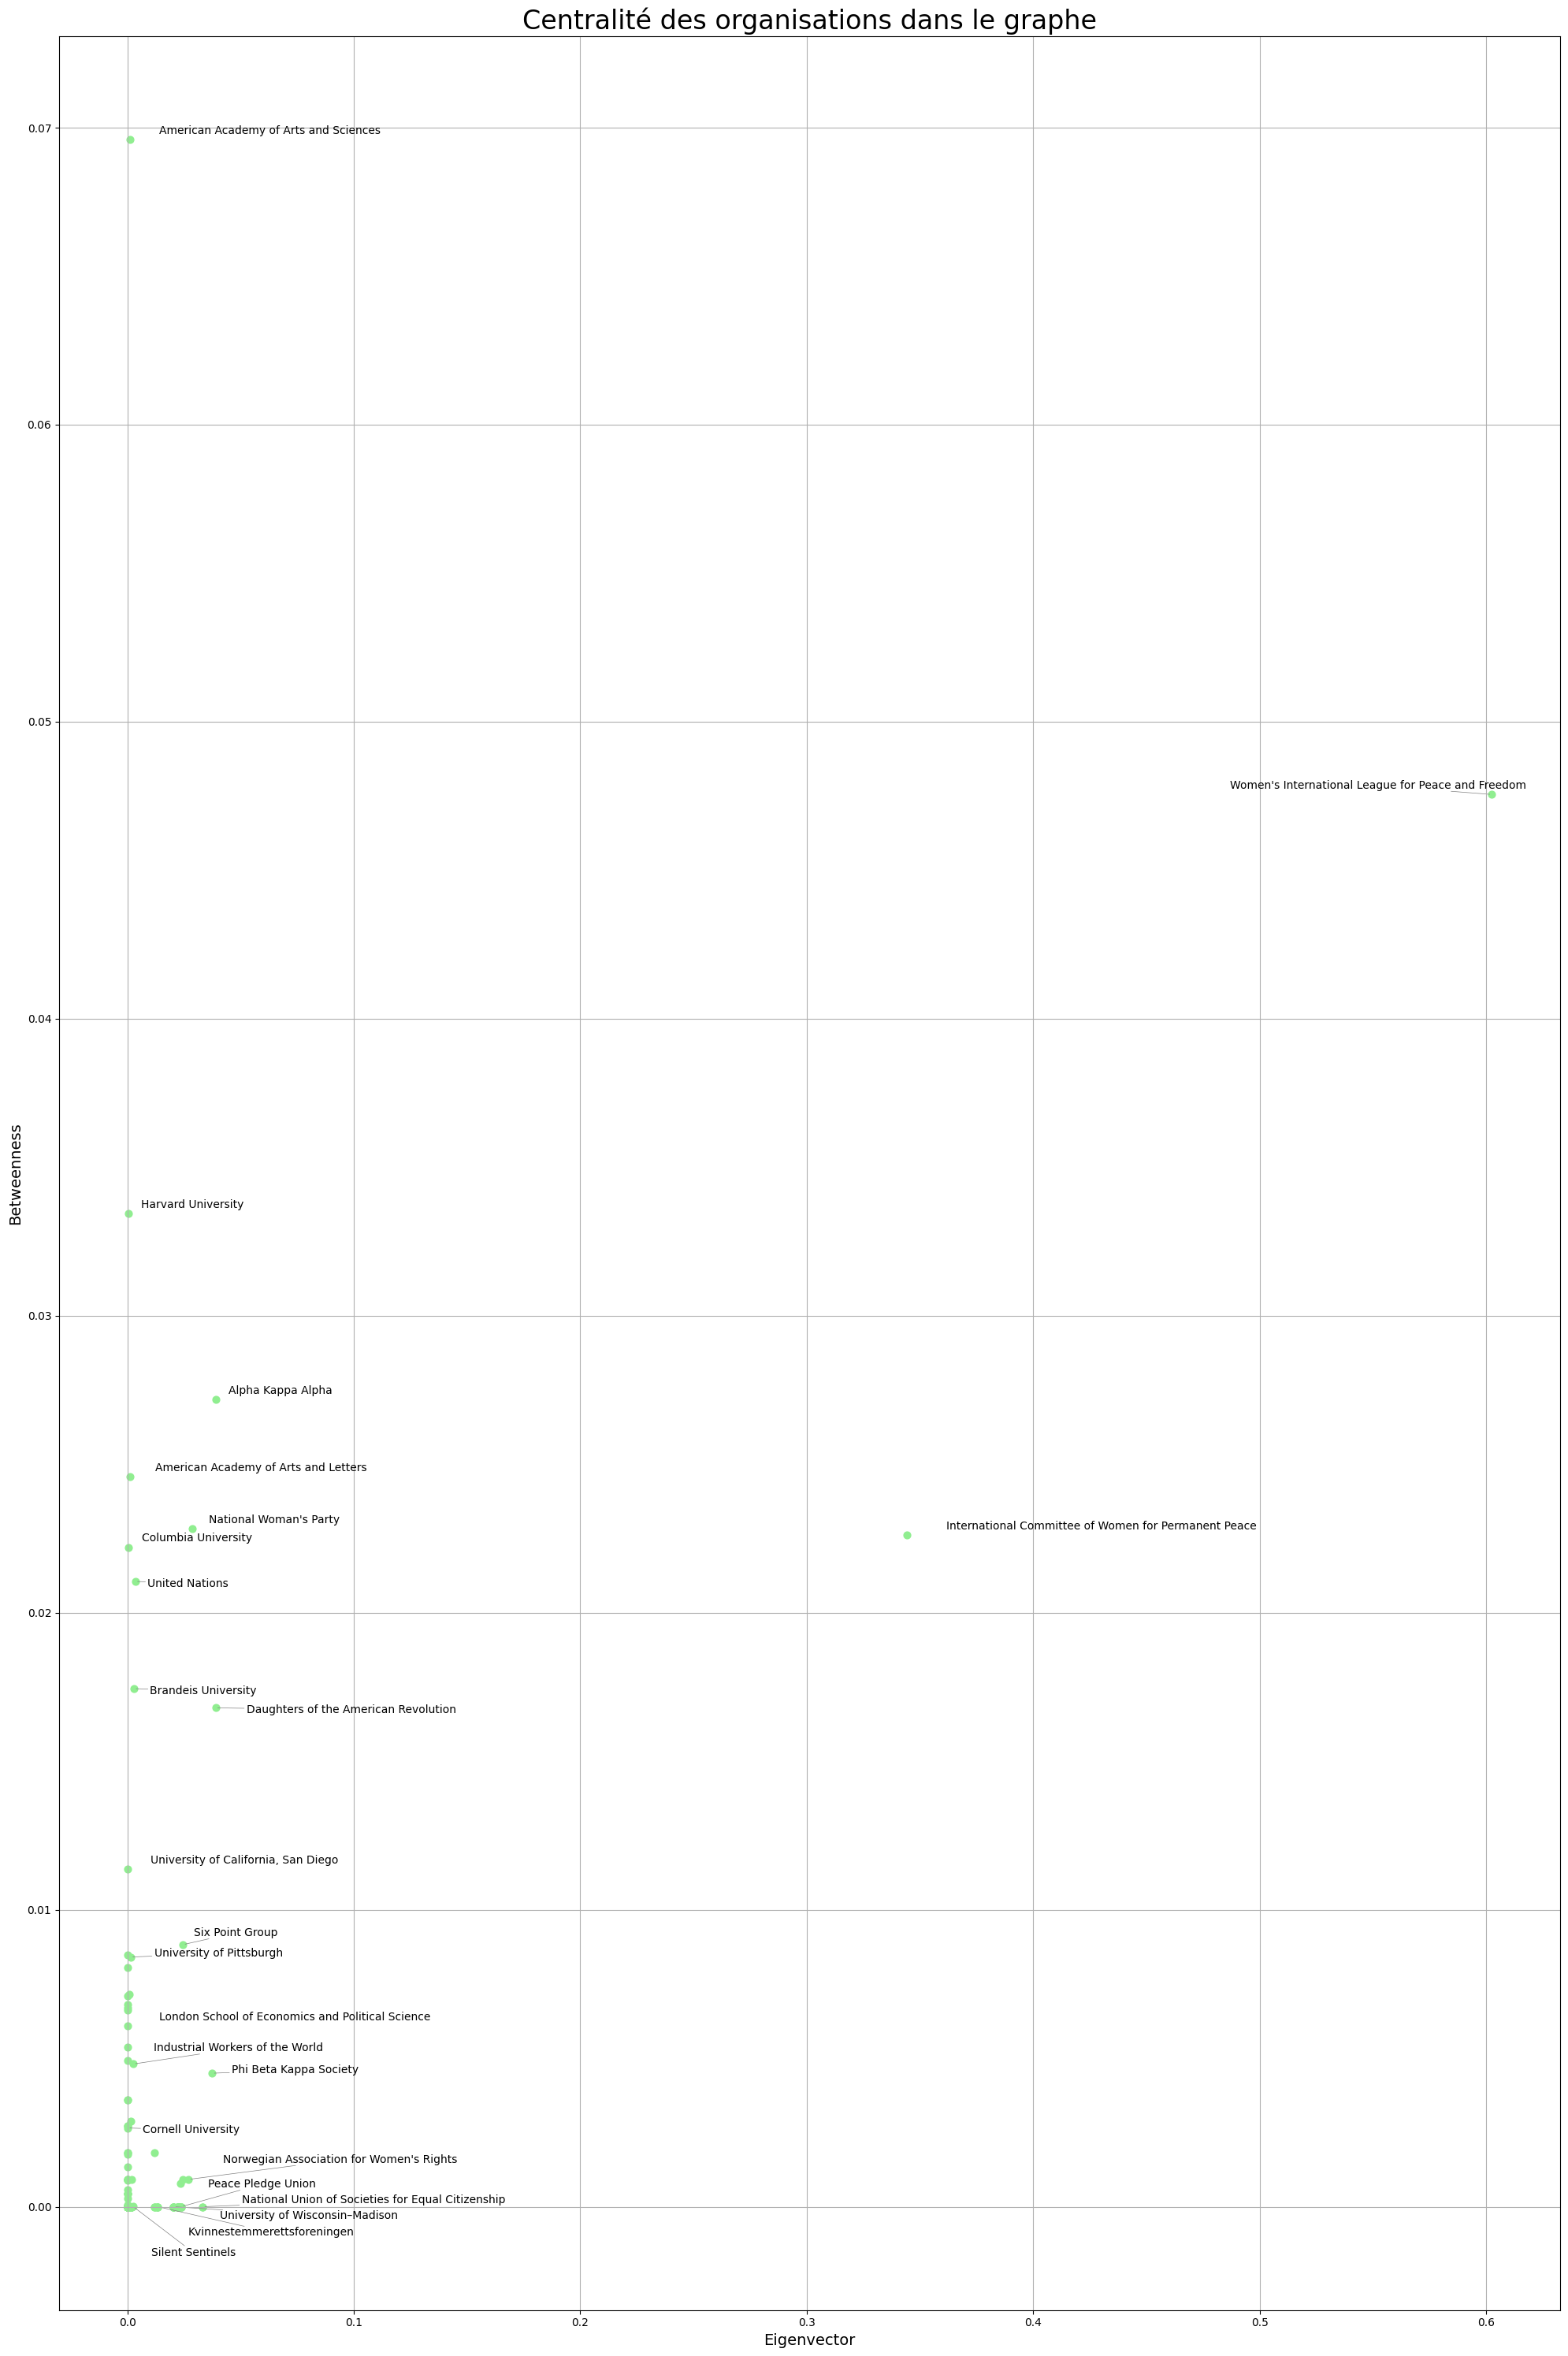

In [91]:
import subprocess
import sys

# --- 1. Installer adjustText automatiquement si nécessaire ---
try:
    from adjustText import adjust_text
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "adjustText"])
    from adjustText import adjust_text  # Import après installation

import matplotlib.pyplot as plt
import numpy as np

# --- 2. Paramètres du graphique ---
plt.figure(figsize=(20, 30))
plt.scatter(df_compare['Eigenvector'], df_compare['Betweenness'], color='lightgreen', s=40)

# --- 3. Afficher uniquement les labels "éloignés" (non superposés)
texts = []
coords = []

# Tolérance : distance minimale pour qu’un label soit affiché
distance_threshold = 0.0025

for i, row in df_compare.iterrows():
    x, y = row['Eigenvector'], row['Betweenness']
    current_point = np.array([x, y])
    
    # Vérifie si trop proche d’un label déjà placé
    if all(np.linalg.norm(current_point - np.array(p)) > distance_threshold for p in coords):
        coords.append(current_point)
        texts.append(plt.text(x, y, row['Organisation'], fontsize=10))

# --- 4. Ajustement automatique des textes placés ---
adjust_text(
    texts,
    only_move={'points': 'y', 'text': 'y'},
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.5)
)

# --- 5. Mise en forme ---
plt.xlabel('Eigenvector', fontsize=14)
plt.ylabel('Betweenness', fontsize=14)
plt.title('Centralité des organisations dans le graphe', fontsize=24)
plt.grid(True)
plt.tight_layout()
plt.show()


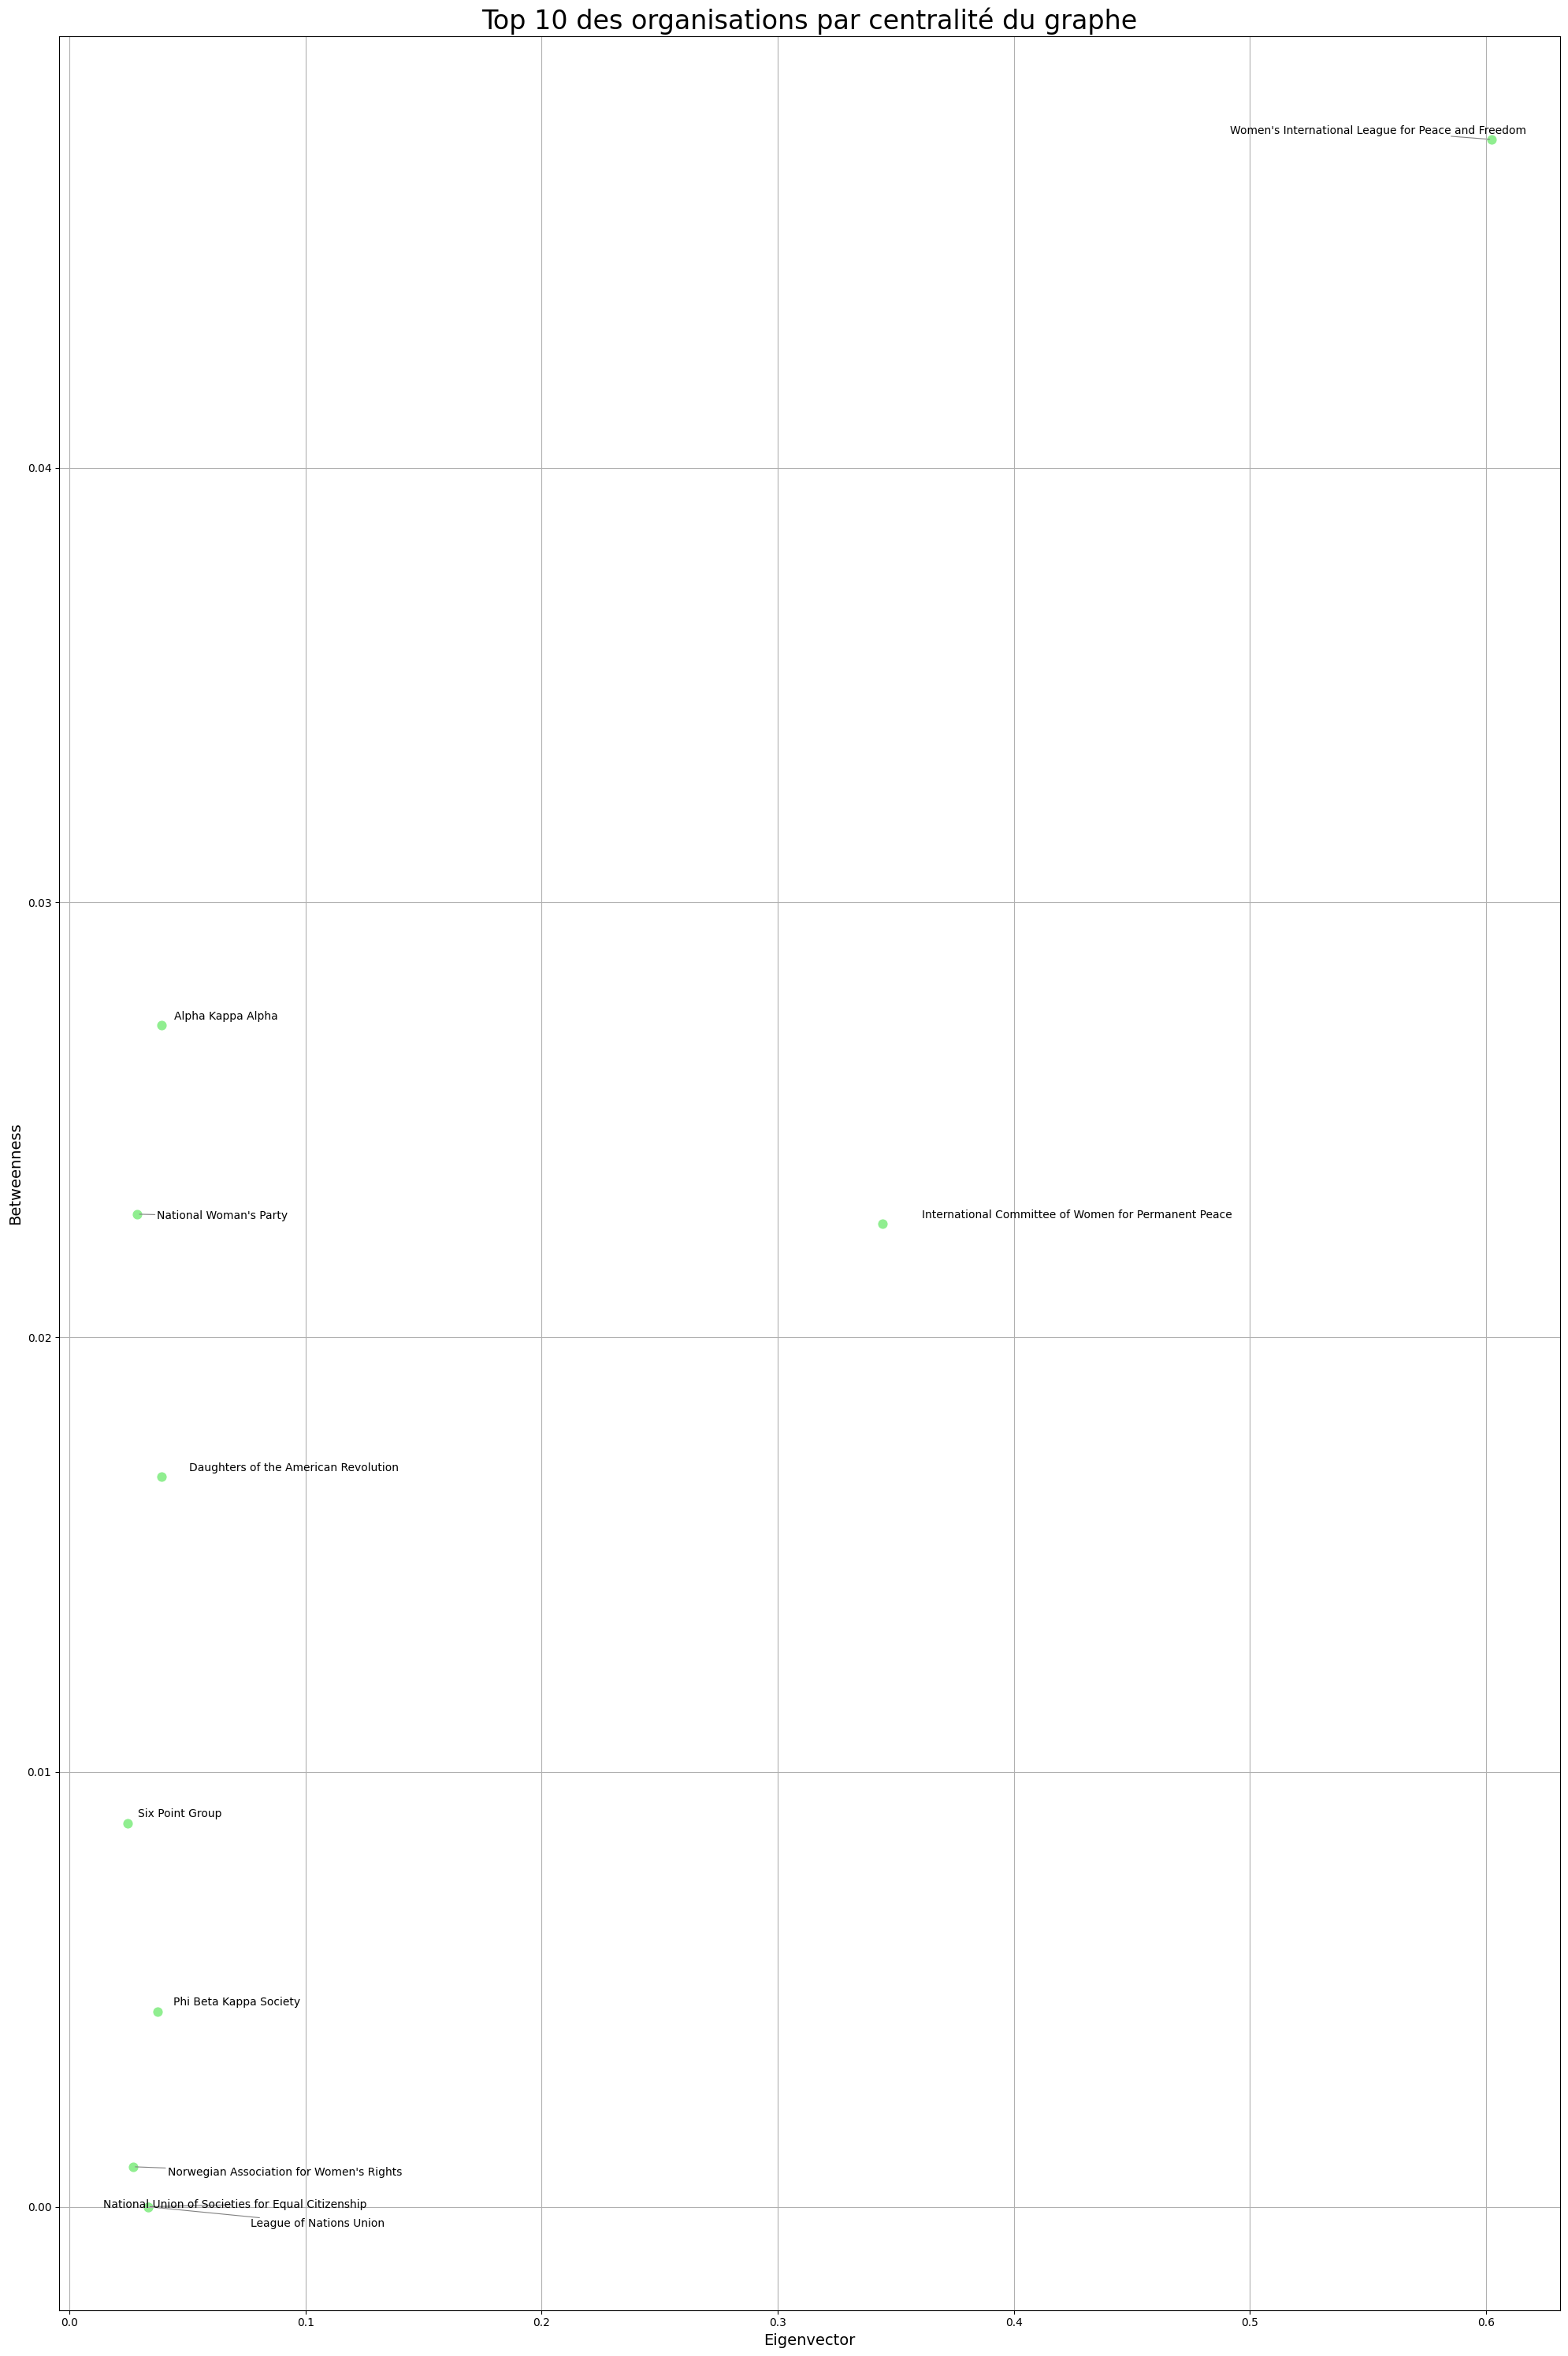

In [99]:
import subprocess
import sys

# --- 1. Installer adjustText automatiquement si nécessaire ---
try:
    from adjustText import adjust_text
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "adjustText"])
    from adjustText import adjust_text

import matplotlib.pyplot as plt
import numpy as np

# --- ⚠️ Filtrer le top 10 des organisations ---
df_top10 = df_compare.sort_values(by='Eigenvector', ascending=False).head(10)

# --- 2. Paramètres du graphique ---
plt.figure(figsize=(20, 30))
plt.scatter(df_top10['Eigenvector'], df_top10['Betweenness'], color='lightgreen', s=60)

# --- 3. Affichage des labels (tous sont déjà filtrés) ---
texts = []
for i, row in df_top10.iterrows():
    x, y = row['Eigenvector'], row['Betweenness']
    texts.append(plt.text(x, y, row['Organisation'], fontsize=10))

# --- 4. Ajustement automatique des textes ---
adjust_text(
    texts,
    only_move={'points': 'y', 'text': 'y'},
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.8)
)

# --- 5. Mise en forme ---
plt.xlabel('Eigenvector', fontsize=14)
plt.ylabel('Betweenness', fontsize=14)
plt.title('Top 10 des organisations par centralité du graphe', fontsize=24)
plt.grid(True)
plt.tight_layout()
plt.show()
